In [2]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-13 02:38:17.663962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 02:38:20.672891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-12 19:16:40.258094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"
dir_path2 = "/global/cfs/cdirs/atlas/wcharm/v12.10/2018/merged"

files = os.listdir(dir_path)
files2 = os.listdir(dir_path2)

TTree = process_ntuple(dir_path, files[0])
SherpaTTree = process_ntuple(dir_path2, files2[4])

In [4]:
branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"]
#Sherpa_df = generate_df(SherpaTTree, branches, 0)
Sherpa_df = show(0, SherpaTTree, branches, 0)
Sherpa_df = remove_empty(Sherpa_df)

Sherpa_df["DMesons_pt"] = Sherpa_df["DMesons_pt"].apply(divide_by_1000)
for col in Sherpa_df.columns:
    Sherpa_df[col] = Sherpa_df[col].apply(list)
Sherpa_df = apply_cuts(Sherpa_df)

In [5]:
Sherpa_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,"[19.12795703125, 19.58577734375, 13.9136142578...","[1.647054672241211, 1.6435248851776123, 1.6656...","[1784.0706787109375, 2405.803466796875, 2107.0...","[1.2497750520706177, 1.6334234476089478, 3.936...","[-0.7660992741584778, 0.8506016731262207, 0.65...","[-411, 4122, 4122, 4122, -4122, -4122, 4122]"
1,"[11.16509765625, 10.5241943359375, 9.593689453...","[-1.7250146865844727, -1.711297631263733, -1.7...","[2227.20556640625, 2199.820068359375, 2213.756...","[0.09700096398591995, 0.1839810311794281, 0.00...","[-0.8130446672439575, -0.7865216732025146, -0....","[4122, 4122, 4122, 4122, 4122, 4122, 4122]"
2,[14.1763544921875],[-2.4057934284210205],[2259.03271484375],[0.5230246782302856],[0.9857037663459778],[4122]
3,"[38.3087421875, 38.790703125, 18.2094453125, 6...","[-2.3254332542419434, -2.316429615020752, -2.3...","[1708.94140625, 1900.1624755859375, 1723.11010...","[0.5003445744514465, 0.6935873627662659, 0.738...","[-0.8833536505699158, -0.8327195644378662, -0....","[-411, -411, 411, 411, -411, -411, -411, 4122,..."
4,[10.61038671875],[1.3017048835754395],[2266.762451171875],[0.4508071839809418],[0.9541121125221252],[4122]
...,...,...,...,...,...,...
126158,"[9.8697587890625, 9.8697587890625]","[1.430569052696228, 1.430569052696228]","[2255.559814453125, 2335.4169921875]","[0.026711689308285713, 0.026711689308285713]","[0.1876566857099533, 0.23284253478050232]","[4122, 4122]"
126159,"[185.8403125, 42.4949453125]","[1.5651028156280518, 1.5765565633773804]","[2255.46826171875, 2149.80859375]","[0.2488638460636139, 0.03478487581014633]","[-0.8009378910064697, 0.9729851484298706]","[-4122, -4122]"
126160,"[8.893080078125, 19.432501953125, 15.837793945...","[-0.9654058218002319, -0.8400431275367737, -0....","[2489.36083984375, 2315.9775390625, 2474.23046...","[0.027805371209979057, 0.31609225273132324, 0....","[-0.9053525924682617, 0.07878544926643372, -0....","[4122, 4122, 4122, -4122, -4122, -4122, -4122,..."
126161,"[26.085296875, 21.54124609375, 16.183518554687...","[-2.1271984577178955, -2.0417397022247314, -2....","[2101.408447265625, 2158.864013671875, 2475.54...","[0.009552433155477047, 0.25102490186691284, 0....","[0.864434540271759, 0.47531265020370483, 0.742...","[4122, 4122, 4122, -4122, -4122, -4122, -4122]"


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [6]:
#save to disk
with open('pickled/Sherpa_df.pickle', 'wb') as f:
    pickle.dump(Sherpa_df, f)


In [6]:
#open
with open('pickled/Sherpa_df.pickle', 'rb') as f:
    Sherpa_df = pickle.load(f)

Sherpa_df

,DMesons_pt,DMesons_eta,DMesons_phi,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,"[51.824703125, 74.569515625, 56.8061015625, 25...","[0.6286062598228455, 0.6233035922050476, 0.633...","[3.133671998977661, 3.140317440032959, 3.13303...","[0.7521379590034485, 0.8251543641090393, 32.68...","[-0.9669413566589355, -0.9921485781669617, -0....","[411, 411, 411, -411, 411, 411, 411, 411, 411,..."
1,"[6.10940185546875, 5.0645224609375, 70.8280156...","[1.1259814500808716, 2.0592145919799805, 0.920...","[-3.118624448776245, 2.8122141361236572, 0.211...","[0.5662250518798828, 0.8943998217582703, 0.727...","[-0.005461902357637882, -0.9238138794898987, -...","[-411, 411, -411, 411, -411, -411, 411, 411, -..."
2,"[37.755640625, 66.324953125, 42.853859375, 37....","[0.14409920573234558, 0.1384088397026062, 0.13...","[2.8637607097625732, 2.8704235553741455, 2.873...","[1.165694236755371, 1.18368399143219, 1.314293...","[-0.9867473244667053, 0.9703434705734253, -0.7...","[411, 411, 411, -411, -411, 411, 411, -411, 41..."
3,"[18.38417578125, 6.29525634765625, 6.295256347...","[0.656701922416687, -0.7559918165206909, -0.75...","[-0.5981934070587158, -2.9346978664398193, -2....","[0.6978135108947754, 0.5700080990791321, 0.570...","[0.8764437437057495, 0.9289295077323914, 0.955...","[411, 4122, 4122, -4122, -4122]"
4,"[13.1462568359375, 7.8361767578125, 7.38871484...","[2.384765863418579, 2.349076271057129, 2.34768...","[-3.0476253032684326, -2.92938494682312, -2.92...","[0.5531177520751953, 5.567208766937256, 7.1613...","[-0.9877780079841614, -0.8886469006538391, -0....","[411, 411, 411, 411, 411, 411, -411, -411, -41..."
...,...,...,...,...,...,...
2387756,"[11.733521484375, 9.95708203125, 5.371853515625]","[-2.148300886154175, -2.122854232788086, 0.336...","[-3.0219995975494385, -3.0114474296569824, -1....","[0.9334728121757507, 2.5765035152435303, 0.060...","[0.7430766820907593, -0.9185329675674438, 0.36...","[-4122, 4122, 4122]"
2387757,"[43.25380859375, 54.54727734375, 37.93190625, ...","[0.9164380431175232, 0.9077516198158264, 0.920...","[1.4878844022750854, 1.488825798034668, 1.4992...","[0.5273526906967163, 0.740077793598175, 0.5003...","[-0.9384782910346985, -0.9834170937538147, -0....","[-411, -411, -411, -4122, -4122, -4122, -4122,..."
2387758,"[12.880916015625, 15.2222109375, 6.38359228515...","[-0.0521884523332119, -0.11672080308198929, -2...","[-1.0410559177398682, -0.9987373352050781, -1....","[0.6400265097618103, 0.883327305316925, 0.6822...","[-0.6596559882164001, -0.697429895401001, 0.45...","[411, 411, -411, -411, 411, -411, -411, -411, ..."
2387759,"[7.6625244140625, 9.7997333984375, 6.286064941...","[-0.18552862107753754, -0.14414754509925842, 0...","[2.0861623287200928, 2.057295322418213, -1.818...","[0.5810241103172302, 0.11571046710014343, 0.03...","[-0.9585545659065247, -0.3123775124549866, -0....","[411, 4122, -4122, -4122, -4122, 4122]"


In [58]:
DMesons_df2 = show(0, TTree, ["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"], 100)
DMesons_df2 = remove_empty(DMesons_df2)

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df2.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

#for now just remove the rows
indices = [i for i, x in enumerate(DMesons_df2[DMesons_df2.columns[0]]) if len(x) > 2]
DMesons_df2 = DMesons_df2.drop(indices)
DMesons_df2 = DMesons_df2.reset_index(drop=True)
DMesons_df2["DMesons_daughterInfo__pt"] = DMesons_df2["DMesons_daughterInfo__pt"].apply(divide_by_1000)
DMesons_df2

pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', None)

# print("-----------------")
# print(DMesons_df.iloc[32, 0][2])
# print(DMesons_df.iloc[32, 1][2])
# print(DMesons_df.iloc[32, 2][2])
# print(DMesons_df.iloc[32, 3][2])

In [ ]:
# create a new column 'particle_type' based on the pdgId column
#func = lambda x: 'only_411' if x == [411] else ('only_4122' if x == [4122] else 'both')

# def func(x):
#     if x == [411]:
#         return 'only_411'
#     elif x == [4122]:
#         return 'only_4122'
#     else:
#         return 'both'

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
both = DMesons_df[DMesons_df['particle_type'] == 'both']

new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)

new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_m'] = new_df['DMesons_m'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x[0]))
new_df = new_df.drop('particle_type', axis=1)
new_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,particle_type
0,"[19.12795703125, 19.58577734375, 13.9136142578...","[1.647054672241211, 1.6435248851776123, 1.6656...","[1784.0706787109375, 2405.803466796875, 2107.0...","[1.2497750520706177, 1.6334234476089478, 3.936...","[-0.7660992741584778, 0.8506016731262207, 0.65...","[-411, 4122, 4122, 4122, -4122, -4122, 4122]",both
1,"[11.16509765625, 10.5241943359375, 9.593689453...","[-1.7250146865844727, -1.711297631263733, -1.7...","[2227.20556640625, 2199.820068359375, 2213.756...","[0.09700096398591995, 0.1839810311794281, 0.00...","[-0.8130446672439575, -0.7865216732025146, -0....","[4122, 4122, 4122, 4122, 4122, 4122, 4122]",both
2,[14.1763544921875],[-2.4057934284210205],[2259.03271484375],[0.5230246782302856],[0.9857037663459778],[4122],both
3,"[38.3087421875, 38.790703125, 18.2094453125, 6...","[-2.3254332542419434, -2.316429615020752, -2.3...","[1708.94140625, 1900.1624755859375, 1723.11010...","[0.5003445744514465, 0.6935873627662659, 0.738...","[-0.8833536505699158, -0.8327195644378662, -0....","[-411, -411, 411, 411, -411, -411, -411, 4122,...",both
4,[10.61038671875],[1.3017048835754395],[2266.762451171875],[0.4508071839809418],[0.9541121125221252],[4122],both
...,...,...,...,...,...,...,...
126158,"[9.8697587890625, 9.8697587890625]","[1.430569052696228, 1.430569052696228]","[2255.559814453125, 2335.4169921875]","[0.026711689308285713, 0.026711689308285713]","[0.1876566857099533, 0.23284253478050232]","[4122, 4122]",both
126159,"[185.8403125, 42.4949453125]","[1.5651028156280518, 1.5765565633773804]","[2255.46826171875, 2149.80859375]","[0.2488638460636139, 0.03478487581014633]","[-0.8009378910064697, 0.9729851484298706]","[-4122, -4122]",both
126160,"[8.893080078125, 19.432501953125, 15.837793945...","[-0.9654058218002319, -0.8400431275367737, -0....","[2489.36083984375, 2315.9775390625, 2474.23046...","[0.027805371209979057, 0.31609225273132324, 0....","[-0.9053525924682617, 0.07878544926643372, -0....","[4122, 4122, 4122, -4122, -4122, -4122, -4122,...",both
126161,"[26.085296875, 21.54124609375, 16.183518554687...","[-2.1271984577178955, -2.0417397022247314, -2....","[2101.408447265625, 2158.864013671875, 2475.54...","[0.009552433155477047, 0.25102490186691284, 0....","[0.864434540271759, 0.47531265020370483, 0.742...","[4122, 4122, 4122, -4122, -4122, -4122, -4122]",both


In [1]:
# D = 0
# Lambda = 0
# for pdgId in new_df["DMesons_pdgId"]:
#     if pdgId == 411:
#         D+=1
#     elif pdgId == 4122:
#         Lambda+=1
# print(D, Lambda)

In [8]:
only_411 = only_411.reset_index(drop=True)
only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_eta'] = only_411['DMesons_eta'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_m'] = only_411['DMesons_m'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_fitOutput__Lxy'] = only_411['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_costhetastar'] = only_411['DMesons_costhetastar'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_pdgId'] = only_411['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_411 = only_411.drop('particle_type', axis=1)

only_4122 = only_4122.reset_index(drop=True)
only_4122.loc[:, 'DMesons_pt'] = only_4122['DMesons_pt'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_eta'] = only_4122['DMesons_eta'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_m'] = only_4122['DMesons_m'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_fitOutput__Lxy'] = only_4122['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_costhetastar'] = only_4122['DMesons_costhetastar'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_pdgId'] = only_4122['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_4122 = only_4122.drop('particle_type', axis=1)

new_df = new_df.drop('DMesons_m', axis=1)
only_411 = only_411.drop('DMesons_m', axis=1)
only_4122 = only_4122.drop('DMesons_m', axis=1)

only_411

/tmp/ipykernel_39485/3838657620.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
/tmp/ipykernel_39485/3838657620.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  only_411.loc[:, 'DMesons_eta'] = only_411['DMesons_eta'].apply(lambda x: float(x[0]))
/tmp/ipykernel_39485/3838657620.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavio

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,0.081824,2.339530,0.254870,411
1,14.835231,-0.928085,2.899070,0.684572,411
2,9.691489,1.568715,1.241371,0.439036,411
3,28.525160,-1.046752,1.982312,0.528804,411
4,40.980965,-2.036715,4.664388,0.302332,411
...,...,...,...,...,...
1566661,23.254861,-0.435785,1.341532,0.385443,411
1566662,24.477744,-0.272090,3.593372,0.539289,411
1566663,14.971446,-1.956944,2.374407,0.863583,411
1566664,12.734207,-0.039695,5.151422,0.461929,411


In [38]:
# Read
with open('pickled/Sherpa_ready.pickle', 'rb') as f:
    DMesons_ready = pickle.load(f)

with open('pickled/Sherpa_only_411.pickle', 'rb') as f:
    only_411 = pickle.load(f)
    
with open('pickled/Sherpa_only_4122.pickle', 'rb') as f:
    only_4122 = pickle.load(f)

In [39]:
#D and Lambda
DMesons_ready['DMesons_pdgId'] = DMesons_ready['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(DMesons_ready[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], DMesons_ready['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [40]:
print(np.shape(X_train), np.shape(X_test))

X_train

(324603, 4) (81151, 4)


,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar
266767,5.717854,1.027390,0.002118,0.901326
125455,30.903406,-0.890374,1.033835,0.418492
44270,7.574004,0.447874,0.247916,-0.202647
142118,37.751363,-0.456004,0.280037,-0.881946
200493,121.874367,-0.808612,3.884390,0.997146
...,...,...,...,...
259178,30.369764,1.684330,0.617203,-0.752777
365838,13.661908,-1.542714,0.115125,0.693368
131932,21.540609,-0.694940,0.307517,-0.858974
146867,33.752844,1.405772,0.072252,-0.806426


In [13]:
# Write to disk
# with open('DMesons_ready.pickle', 'wb') as f:
#     pickle.dump(new_df, f)

# with open('only_411.pickle', 'wb') as f:
#     pickle.dump(only_411, f)
    
# with open('only_4122.pickle', 'wb') as f:
#     pickle.dump(only_4122, f)

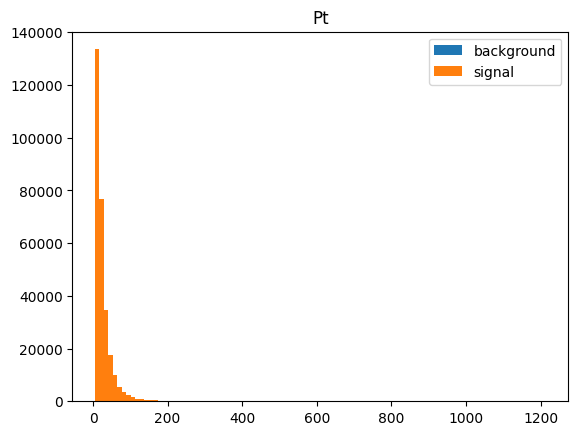

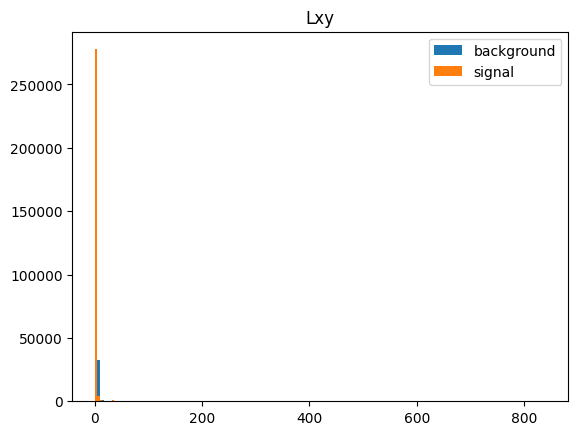

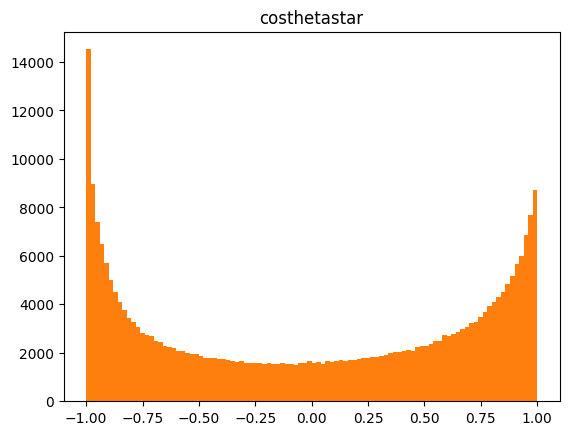

In [41]:
plt.figure()
plt.title("Pt")
hists = plt.hist(X_train1["DMesons_pt"], bins = 100, label = "background")
hists = plt.hist(X_train2["DMesons_pt"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
plt.title("Lxy")
hists1 = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins = 100, label = "background")
hists1 = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
plt.title("costhetastar")
hists2 = plt.hist(X_train1["DMesons_costhetastar"], bins = 100, label = "background")
hists2 = plt.hist(X_train2["DMesons_costhetastar"], bins = 100, label = "signal")
# plt.legend()
# plt.show()

In [42]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 10,
        "batch_size": 32
    }
)


In [43]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

#def custom_accuracy()

Model: "my_model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  320       
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  2080      
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


In [44]:
#Compile
import time

start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss)

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

Epoch 1/10
10124/10144 [============================>.] - ETA: 0s - loss: 0.2955

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best)... Done. 0.0s


10144/10144 [==============================] - 21s 2ms/step - loss: 0.2953 - val_loss: 0.2281
Epoch 2/10
10121/10144 [============================>.] - ETA: 0s - loss: 0.2384

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best)... Done. 0.1s


10144/10144 [==============================] - 20s 2ms/step - loss: 0.2385 - val_loss: 0.2247
Epoch 3/10
10144/10144 [==============================] - 19s 2ms/step - loss: 0.2371 - val_loss: 0.2254
Epoch 4/10
10144/10144 [==============================] - 19s 2ms/step - loss: 0.2362 - val_loss: 0.2357
Epoch 5/10
10127/10144 [============================>.] - ETA: 0s - loss: 0.2351

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best)... Done. 0.0s


10144/10144 [==============================] - 21s 2ms/step - loss: 0.2351 - val_loss: 0.2236
Epoch 6/10
10128/10144 [============================>.] - ETA: 0s - loss: 0.2341

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best)... Done. 0.0s


10144/10144 [==============================] - 20s 2ms/step - loss: 0.2340 - val_loss: 0.2235
Epoch 7/10
10127/10144 [============================>.] - ETA: 0s - loss: 0.2333

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230413_033308-y5dz4ny6/files/model-best)... Done. 0.0s


10144/10144 [==============================] - 21s 2ms/step - loss: 0.2333 - val_loss: 0.2219
Epoch 8/10
10144/10144 [==============================] - 19s 2ms/step - loss: 0.2321 - val_loss: 0.2226
Epoch 9/10
10144/10144 [==============================] - 19s 2ms/step - loss: 0.2321 - val_loss: 0.2230
Epoch 10/10
10144/10144 [==============================] - 19s 2ms/step - loss: 0.2311 - val_loss: 0.2279
Epoch 10: early stopping
2536/2536 [==============================] - 3s 1ms/step - loss: 0.2279
Loss: 0.22792109847068787
Training runtime: 201.60693907737732 seconds


2023-04-13 03:33:45.389203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-13 03:33:45.404730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-13 03:33:45.555928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-13 03:33:45

In [45]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_loss,▄▂▃█▂▂▁▁▂▄
best_epoch,6
best_val_loss,0.22195
epoch,9
loss,0.23113
val_loss,0.22792


------------------------------------------ Finished training, now analyze ------------------------------------------

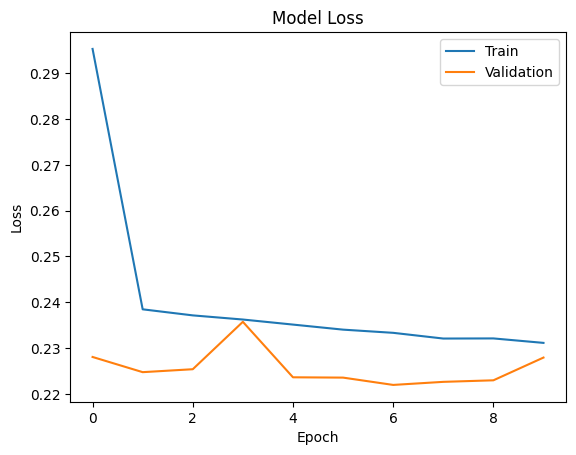

In [46]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [47]:
predictions = model.predict(X_test)
predictions[:10]

2536/2536 [==============================] - 3s 1ms/step


array([[1.       ],
       [1.       ],
       [0.7119351],
       [1.       ],
       [0.9867114],
       [1.       ],
       [0.7353275],
       [1.       ],
       [1.       ],
       [1.       ]], dtype=float32)

In [48]:
predictions1 = model.predict(X_test1)
predictions1[:10]

277/277 [==============================] - 0s 1ms/step


array([[0.9593336 ],
       [0.8487926 ],
       [0.6389179 ],
       [0.775457  ],
       [0.775457  ],
       [0.72520643],
       [0.7600143 ],
       [0.775457  ],
       [0.66150206],
       [0.7450395 ]], dtype=float32)

In [49]:
predictions2 = model.predict(X_test2)
predictions2[:10]

2260/2260 [==============================] - 3s 1ms/step


array([[0.63644487],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.6458826 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.651367  ]], dtype=float32)

In [77]:
predictions_list = []
D_count = 0
Lambda_count = 0
unclear = 0
for pred in predictions:
    if float(pred) > 0.7:
        predictions_list.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.7:
        predictions_list.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions)

$D^+$ Count: 10734
$\Lambda_C^+ Count: 70417
Unknown Particle Count: 0


(81151, 1)

In [78]:
accuracy = np.mean(predictions_list == y_test)
print("Accuracy: {:.2%}".format(accuracy))

y_test

Accuracy: 85.67%


272170    1
376090    1
360419    1
106293    1
29417     1
         ..
120474    1
270336    1
222162    1
146989    1
354989    1
Name: DMesons_pdgId, Length: 81151, dtype: int64

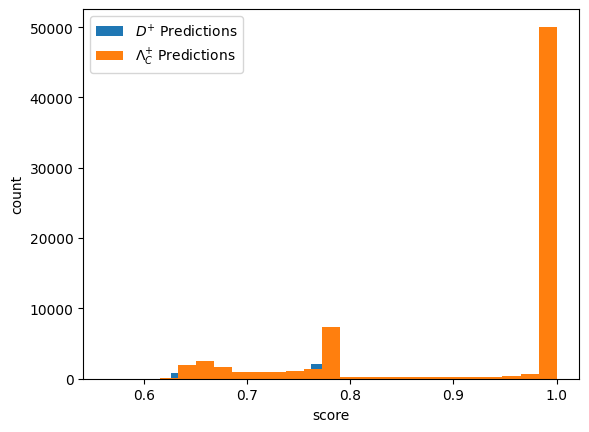

In [75]:
hist = plt.hist(predictions1, bins = 25, label = "$D^{+}$ Predictions")
hist2 = plt.hist(predictions2, bins = 25, label = "$\Lambda_C^{+}$ Predictions")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()

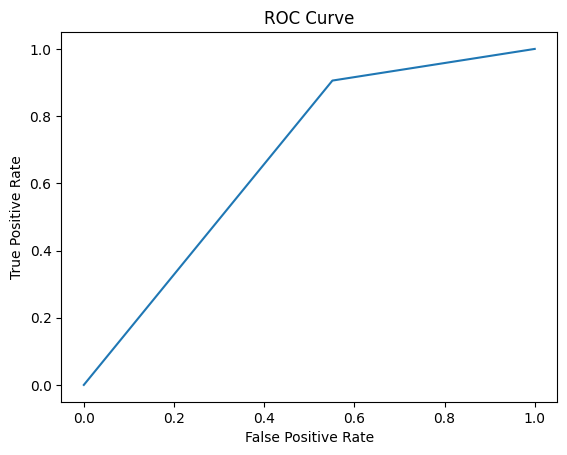

In [79]:
from sklearn.metrics import roc_curve

# Get true labels and predicted probabilities
y_true = y_test
y_pred = predictions_list

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
